# 01. Quickstart

In [1]:
# import the hoomd, htf packages
import hoomd
import hoomd.htf as htf
import tensorflow as tf
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Build the SimModel

We prepare the computations that will be executed at each step during the simulation. We can have access to the neighbor list, positions, types, box dimensions of the simulation, but here we only use the neighbor list. Ignore sample_weight for now. Here we define a piece-wise repulsive potential, compute an RDF, and use the auto-differentiation tool to compute forces. 

In [2]:
class WCAPotential(htf.SimModel):
    def setup(self):
        self.avg_rdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist):
        # Use Weeks-Chandler-Anderson (WCA) repulisve potential
        r12 = htf.nlist_rinv(nlist)**12 # nlist_rinv is neighbor 1 / r^12
        # make it so anything above 2^1/6 is 0
        r = tf.norm(nlist[:,:,:3], axis=2)
        pair_energy = tf.cast(r < 2**(1/6), tf.float32) * r12
        particle_energy = tf.reduce_sum(pair_energy, axis=1) # sum over neighbors        
        forces = htf.compute_nlist_forces(nlist, particle_energy)
        # compute rdf
        inst_rdf = htf.compute_rdf(nlist, [0, 3.5])
        self.avg_rdf.update_state(inst_rdf)
        return forces

## Running the simulation

Now we run the simulation using the usual hoomd-blue syntax. We can specify things like how often the model is called, how often it is saved, etc. in the `attach` command. This simulation is 144 particles in 2D, whose forces are the ones we defined above. 

In [3]:
########### Hoomd-Sim Code ################
hoomd.context.initialize('--mode=cpu')
# this will start TensorFlow, so it goes
# in a with statement for clean exit.
#
# if calling initialize() without params, 
# it will be throw error of using unexpected parameter 'f'
# ref: https://github.com/glotzerlab/hoomd-blue/blob/master/hoomd/context.py#L204

L = 16
N = L * L
model = WCAPotential(64)
tfcompute = htf.tfcompute(model)

# create a square lattice
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.2),
                                    n=[L,L])
nlist = hoomd.md.nlist.cell()
# NVT ensemble with starting temperature of 1
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nvt(group=hoomd.group.all(), kT=0.5, tau=0.5).randomize_velocities(seed=1)
tfcompute.attach(nlist, r_cut=5)
#equilibrate
hoomd.run(1000)
# reset rdf statistics
model.avg_rdf.reset_states()
hoomd.run(1000)

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 256 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions    

## Analysis

Now we'll plot RDF

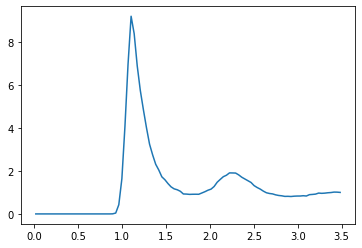

In [4]:
import matplotlib.pyplot as plt
import numpy as np 

rdf = model.avg_rdf.result().numpy()
plt.plot(rdf[1, :], rdf[0, :] / rdf[0,-1])

We can also examine the final positions

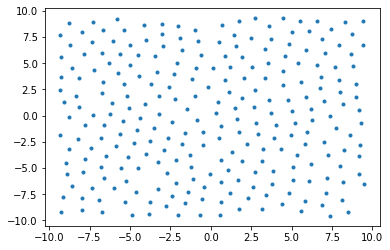

In [5]:
pos = tfcompute.get_positions_array()
plt.plot(pos[:,0], pos[:,1], '.')